In [1]:
!pip install nvidia-cutlass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.5 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Mon Jan 20 22:49:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import collections
import os
import sys

import cutlass
import torch
import triton
import triton.language as tl

In [4]:
@triton.jit
def base_kernel(
    a_ptr,
    b_ptr,
    c_ptr,
    M,
    N,
    K,
    stride_am,
    stride_ak,
    stride_bk,
    stride_bn,
    stride_cm,
    stride_cn,
    GROUP_SIZE_M: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
    """Triton tutorial implementation of the kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def matmul(a, b, kernel, kernel_params: dict):
    """
    Perform matrix multiplication using the provided matmul kernel.

    This is identical to the tutorial implementation, except that we allow for the option of passing in kernel
    parameters directly for later plotting (passing in GROUP_SIZE_M) purposes.

    :param a: input matrix A
    :param b: input matrix B
    :param kernel: the Triton matmul kernel to use
    :param kernel_params: kernel parameters
    """
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    # kernel_opts is used for plotting purposes (e.g, pass in GROUP_SIZE_M directly to matmul instead of to the matmul kernel through the autotuner)

    M, K = a.shape
    K, N = b.shape

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)

    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),)

    kernel[grid](
        a,
        b,
        c,
        M,
        N,
        K,
        a.stride(0),
        a.stride(1),
        b.stride(0),
        b.stride(1),
        c.stride(0),
        c.stride(1),
        **kernel_params,
    )

    return c

In [9]:
def estimate_optimal_conf() -> int:
    """
    Estimate the optimal configuration for matmul by autotuning with a subset of the K values (0, 8193).

    The autotuning process will produce an optimal configuration for each K in the subset.
    We do a greedy estimate by choosing the most frequent configuration across all K.
    The variance of our estimate decreases as we increase the subset size, among other factors.

    :return: the number of configurations used in the autotuning process
    """
    configs = []
    block_size_lst = [64, 128]
    gsm_lst = [4, 8]  # GROUP_SIZE_M
    ns_lst = [2]  # num_stages
    nw_lst = [16, 32]  # num_warps
    for bsm in block_size_lst:
        for bsn in block_size_lst:
            for bsk in block_size_lst:
                for gsm in gsm_lst:
                    for ns in ns_lst:
                        for nw in nw_lst:
                            configs.append(
                                triton.Config(
                                    {
                                        "BLOCK_SIZE_M": bsm,
                                        "BLOCK_SIZE_N": bsn,
                                        "BLOCK_SIZE_K": bsk,
                                        "GROUP_SIZE_M": gsm,
                                    },
                                    num_stages=ns,
                                    num_warps=nw,
                                )
                            )

    # set kernel to be autotunable with the above configs
    auto_kernel = triton.autotune(configs=configs, key=["K"])(base_kernel)

    bench = triton.testing.Benchmark(
        x_names=["K"],
        x_vals=[i for i in range(512, 8193, 512)],  # note that len(x_vals) = 16
        line_arg="provider",
        line_vals=["triton", "cublas", "cutlass"],
        line_names=["Triton", "cuBLAS", "cuTLASS"],
        styles=[("red", "-"), ("blue", "-"), ("green", "-")],
        ylabel="Mean runtime (ms)",
        plot_name=f"per-k-autotuned_matmul_row-major_fp16",
        args={"M": 8192, "N": 8192},
    )

    @triton.testing.perf_report(bench)
    def benchmark(M, N, K, provider):
        a = torch.randn((M, K), device="cuda", dtype=torch.float16)
        b = torch.randn((K, N), device="cuda", dtype=torch.float16)

        plan = cutlass.op.Gemm(element=torch.float16, layout=cutlass.LayoutType.RowMajor)
        # c stores the output of matmul(a, b) and d is a dummy tensor
        c = torch.ones((M, N), device="cuda", dtype=torch.float16)
        d = torch.ones((M, N), device="cuda", dtype=torch.float16)

        if provider == "cublas":
            mean_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
        elif provider == "triton":
            mean_ms = triton.testing.do_bench(lambda: matmul(a, b, auto_kernel, {}))
        elif provider == "cutlass":
            mean_ms = triton.testing.do_bench(lambda: plan.run(a, b, c, d))

        return mean_ms

    benchmark.run(print_data=True, show_plots=True, save_path="./per-k-autotuned_matmul_perf")
    return len(configs)

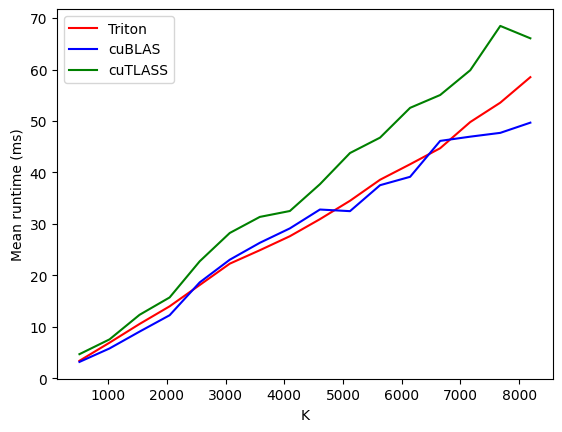

<Figure size 640x480 with 0 Axes>

In [11]:
stdout = sys.stdout
with open("autotuning_output", "w") as sys.stdout:
    os.environ["TRITON_PRINT_AUTOTUNING"] = "1"
    num_configs = estimate_optimal_conf()

sys.stdout = stdout  # reset stdout

In [12]:
def extract_config(line: str) -> tuple[dict, dict]:
    """
    Extract the meta and compilation parameters from a line in the autotuning output.

    :param line: a line in the autotuning output
    :return: two dictionaries containing the meta and compilation parameters
    """
    # find the start and end of the meta parameters
    meta_start = line.find("BLOCK_SIZE_M")
    meta_end = line.find("num_warps") - 2

    # find the start and end of the compilation parameters
    comp_start = meta_end + 2
    comp_end = len(line) - 2

    meta = line[meta_start:meta_end].split(", ")
    comp = line[comp_start:comp_end].split(", ")

    meta_dct = {}
    for param_val in meta:
        param, val = param_val.split(": ")
        meta_dct[param] = int(val)

    comp_dct = {}
    for param_val in comp:
        param, val = param_val.split(": ")
        comp_dct[param] = None if val == "None" else int(val)

    return meta_dct, comp_dct


def get_most_freq_config(file_path: str, num_configs: int) -> tuple[triton.Config, int]:
    """
    Get the most frequent configuration from the autotuning output.

    :param file_path: the path to the autotuning output
    :param num_configs: the number of configurations contained in the file
    :return: the most frequent Triton configuration, excluding GROUP_SIZE_M
    """
    config_counter = collections.Counter()
    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i >= num_configs:
                break
            config_counter[line] += 1

    most_freq, _ = config_counter.most_common(1)[0]

    print(f"Most frequent config: {most_freq}")

    meta_dct, comp_dct = extract_config(most_freq)
    gsm = meta_dct["GROUP_SIZE_M"]
    del meta_dct["GROUP_SIZE_M"]

    return triton.Config(meta_dct, **comp_dct), gsm

In [13]:
optimal_config, optimal_gsm = get_most_freq_config("autotuning_output", num_configs)

Most frequent config: Triton autotuning for function base_kernel finished after 15.87s; best config selected: BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 128, BLOCK_SIZE_K: 64, GROUP_SIZE_M: 8, num_warps: 16, num_ctas: 1, num_stages: 2, maxnreg: None;



In [17]:
def plot_near_optimal(optimal_conf: triton.Config, optimal_gsm) -> None:
    """
    Plot the performance of the matmul kernel for different GROUP_SIZE_M values.

    The plots will include the optimal GROUP_SIZE_M found in the autotuning process; the intent is to show the
    behaviour of the kernel near the (estimated) optimal GROUP_SIZE_M.

    :param optimal_conf: the optimal configuration found in the autotuning process, excludes GROUP_SIZE_M
    """

    # We set the configuration of the kernel using an autotuner with one config; Triton does not seem to provide another way
    optimal_kernel = triton.autotune(configs=[optimal_conf], key=["M", "N"])(base_kernel)  # static

    benches = [
        triton.testing.Benchmark(
            x_names=["K"],
            x_vals=[i for i in range(256, 8193, 256)],
            line_arg="provider",
            line_vals=["triton", "cublas", "cutlass"],
            line_names=["Triton", "cuBLAS", "cuTLASS"],
            styles=[("red", "-"), ("green", "-"), ("blue", "-")],
            ylabel="Time (ms)",
            plot_name=f"GSM{GSM}_autotuned_matmul_row-major_fp16",
            args={
                "M": 8192,
                "N": 8192,
                "GSM": GSM,
            },
        )
        for GSM in list({optimal_gsm - 2 * i for i in range(4)} | {optimal_gsm + 2 * i for i in range(4)})
    ]

    @triton.testing.perf_report(benches)
    def benchmark(M, N, K, GSM, provider):
        a = torch.randn((M, K), device="cuda", dtype=torch.float16)
        b = torch.randn((K, N), device="cuda", dtype=torch.float16)

        plan = cutlass.op.Gemm(element=torch.float16, layout=cutlass.LayoutType.RowMajor)
        # c stores the output of matmul(a, b) and d is a dummy tensor
        c = torch.ones((M, N), device="cuda", dtype=torch.float16)
        d = torch.ones((M, N), device="cuda", dtype=torch.float16)

        if provider == "cublas":
            mean_ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
        elif provider == "triton":
            mean_ms = triton.testing.do_bench(lambda: matmul(a, b, optimal_kernel, {"GROUP_SIZE_M": GSM}))
        elif provider == "cutlass":
            mean_ms = triton.testing.do_bench(lambda: plan.run(a, b, c, d))

        return mean_ms

    benchmark.run(print_data=True, show_plots=True, save_path="./autotuned_matmul_perf")

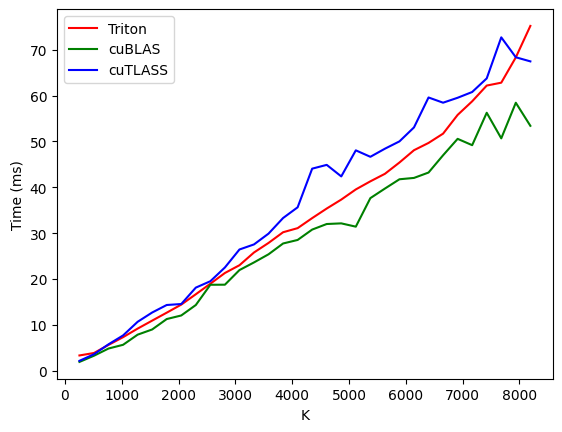

GSM2_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   3.338611   1.927263   2.165024
1    512.0   3.871315   3.278902   3.601575
2    768.0   5.641099   4.848612   5.770996
3   1024.0   7.323180   5.660522   7.702413
4   1280.0   9.190599   7.869489  10.674006
5   1536.0  10.932017   9.004008  12.701430
6   1792.0  12.665009  11.274987  14.337956
7   2048.0  14.424932  12.054859  14.550033
8   2304.0  16.681147  14.333936  18.125984
9   2560.0  18.976664  18.748051  19.521065
10  2816.0  21.314905  18.765232  22.517471
11  3072.0  23.006760  21.951183  26.437632
12  3328.0  25.786272  23.619345  27.544790
13  3584.0  27.871679  25.394453  29.898848
14  3840.0  30.200438  27.748489  33.301174
15  4096.0  31.093260  28.518335  35.635151
16  4352.0  33.280258  30.781067  44.063538
17  4608.0  35.368431  31.993887  44.888817
18  4864.0  37.321297  32.135082  42.370911
19  5120.0  39.534126  31.416330  48.055904
20  5376.0  41.299377  37.636993  46.6

<Figure size 640x480 with 0 Axes>

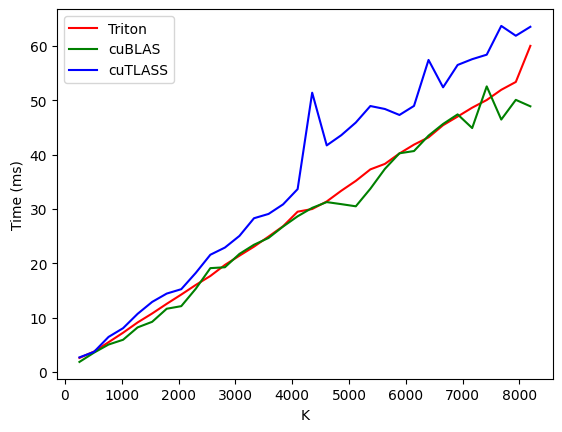

GSM4_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   2.594621   1.856292   2.693865
1    512.0   3.766207   3.561872   3.705322
2    768.0   5.482305   5.057222   6.457225
3   1024.0   7.232599   5.936009   8.069982
4   1280.0   9.126436   8.214698  10.712248
5   1536.0  10.775781   9.243380  12.905769
6   1792.0  12.554634  11.647146  14.439227
7   2048.0  14.258067  12.124300  15.247488
8   2304.0  16.032780  15.336186  18.255791
9   2560.0  17.679728  19.122623  21.589079
10  2816.0  19.715120  19.283520  22.909622
11  3072.0  21.415871  21.742943  25.056181
12  3328.0  23.079081  23.430410  28.309237
13  3584.0  24.933792  24.680298  29.100458
14  3840.0  26.841291  26.778593  30.862772
15  4096.0  29.516960  28.665909  33.674164
16  4352.0  30.005791  30.218348  51.421745
17  4608.0  31.398262  31.282099  41.723022
18  4864.0  33.369473  30.905762  43.596252
19  5120.0  35.185310  30.507063  45.928448
20  5376.0  37.304733  33.741856  48.9

<Figure size 640x480 with 0 Axes>

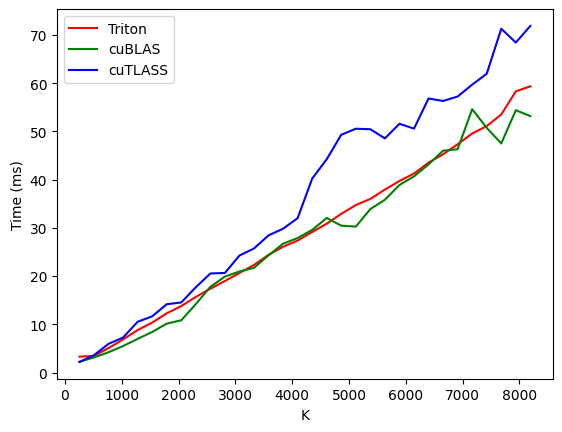

GSM6_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   3.282095   2.223350   2.197337
1    512.0   3.452180   3.129819   3.597670
2    768.0   5.071692   4.199210   5.950832
3   1024.0   6.864174   5.488440   7.254371
4   1280.0   8.803576   6.973168  10.524288
5   1536.0  10.357756   8.413157  11.646951
6   1792.0  12.270241  10.137936  14.161140
7   2048.0  13.785909  10.835979  14.531803
8   2304.0  15.680794  14.193563  17.687584
9   2560.0  17.370617  17.770731  20.538103
10  2816.0  18.982769  19.894871  20.644711
11  3072.0  20.649464  20.949472  24.259829
12  3328.0  22.308662  21.715879  25.722528
13  3584.0  24.402550  24.311159  28.439936
14  3840.0  26.084948  26.711252  29.826410
15  4096.0  27.367380  27.891724  32.015423
16  4352.0  29.150240  29.577484  40.205173
17  4608.0  30.870035  32.053642  44.234161
18  4864.0  32.913422  30.456320  49.308224
19  5120.0  34.726318  30.257025  50.556206
20  5376.0  36.006336  33.897778  50.4

<Figure size 640x480 with 0 Axes>

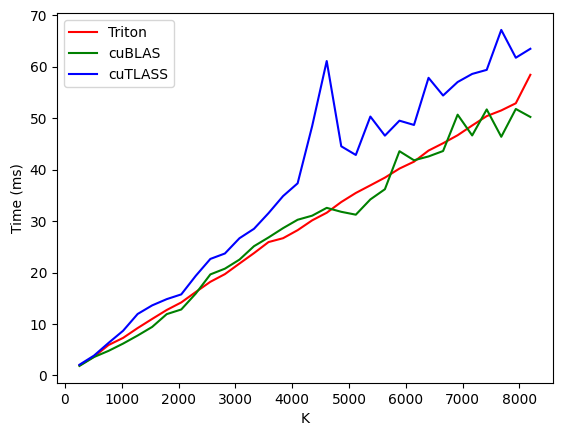

GSM8_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   1.960241   1.858914   2.088248
1    512.0   3.650382   3.583561   3.864542
2    768.0   5.919438   4.784308   6.332202
3   1024.0   7.304442   6.196920   8.688237
4   1280.0   9.214724   7.762902  11.950344
5   1536.0  10.990313   9.439312  13.624375
6   1792.0  12.729707  11.923228  14.836782
7   2048.0  14.197235  12.827374  15.760353
8   2304.0  16.232428  15.926566  19.380312
9   2560.0  18.205456  19.642809  22.649830
10  2816.0  19.696766  20.755592  23.706816
11  3072.0  21.749472  22.513351  26.669077
12  3328.0  23.778368  25.123991  28.503798
13  3584.0  25.927147  26.821695  31.548876
14  3840.0  26.678932  28.632853  34.864208
15  4096.0  28.237259  30.262270  37.342079
16  4352.0  30.149248  31.056351  48.474174
17  4608.0  31.626272  32.576015  61.106018
18  4864.0  33.707920  31.806038  44.535744
19  5120.0  35.467506  31.247316  42.852127
20  5376.0  36.947937  34.213200  50.3

<Figure size 640x480 with 0 Axes>

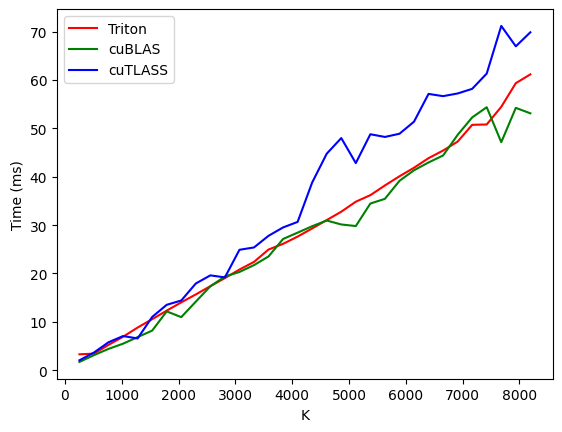

GSM10_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   3.291935   1.717109   2.053332
1    512.0   3.429565   3.122402   3.662050
2    768.0   5.244254   4.415500   5.784149
3   1024.0   6.927175   5.492035   7.065492
4   1280.0   8.823992   6.848514   6.570464
5   1536.0  10.553328   8.195138  11.016547
6   1792.0  12.321408  12.165731  13.526683
7   2048.0  14.034416  10.977076  14.416976
8   2304.0  15.669492  14.183396  17.931099
9   2560.0  17.385134  17.357227  19.614298
10  2816.0  19.051439  19.370712  19.191994
11  3072.0  20.810823  20.316904  24.900991
12  3328.0  22.398302  21.733150  25.386057
13  3584.0  24.956884  23.529642  27.793365
14  3840.0  26.130091  27.135691  29.522444
15  4096.0  27.634987  28.449453  30.670050
16  4352.0  29.316107  29.773867  38.815331
17  4608.0  31.044382  30.953291  44.768303
18  4864.0  32.778862  30.136789  48.005180
19  5120.0  34.845886  29.809717  42.827423
20  5376.0  36.197632  34.462654  48.

<Figure size 640x480 with 0 Axes>

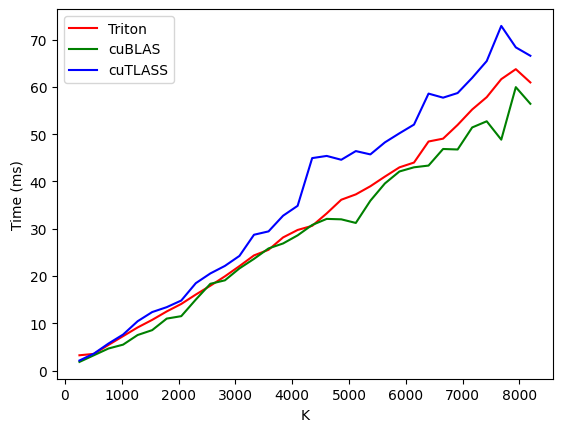

GSM12_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   3.267196   1.863361   2.163715
1    512.0   3.564720   3.283887   3.635091
2    768.0   5.464369   4.702398   5.757373
3   1024.0   7.310304   5.515149   7.645413
4   1280.0   9.149968   7.548487  10.462475
5   1536.0  10.748178   8.581766  12.400608
6   1792.0  12.534011  11.019420  13.438175
7   2048.0  14.117056  11.535872  14.839835
8   2304.0  16.104389  15.040388  18.507627
9   2560.0  17.967848  18.375385  20.565680
10  2816.0  19.952961  19.110033  22.157425
11  3072.0  22.114056  21.629410  24.270559
12  3328.0  24.374304  23.645247  28.742826
13  3584.0  25.563850  25.850090  29.452982
14  3840.0  28.178431  26.902132  32.767826
15  4096.0  29.753611  28.613962  34.858368
16  4352.0  30.627764  30.809982  44.943104
17  4608.0  33.255489  32.095200  45.401138
18  4864.0  36.142319  32.002110  44.590385
19  5120.0  37.274033  31.238047  46.426304
20  5376.0  38.993023  35.932976  45.

<Figure size 640x480 with 0 Axes>

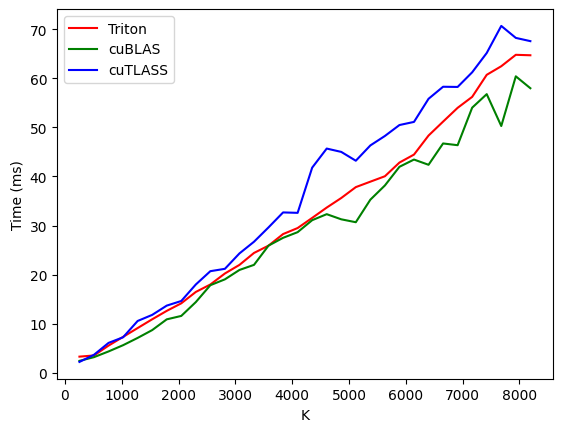

GSM14_autotuned_matmul_row-major_fp16:
         K     Triton     cuBLAS    cuTLASS
0    256.0   3.271258   2.409877   2.194396
1    512.0   3.511109   3.168476   3.651317
2    768.0   5.519099   4.330426   6.071541
3   1024.0   7.297315   5.605205   7.218265
4   1280.0   9.097064   7.087175  10.539875
5   1536.0  10.882523   8.680167  11.781552
6   1792.0  12.599019  10.871767  13.670197
7   2048.0  14.140639  11.570912  14.615344
8   2304.0  16.458950  14.391548  17.978695
9   2560.0  17.977200  17.835333  20.692663
10  2816.0  20.222641  19.027367  21.172039
11  3072.0  21.973032  20.940857  24.311945
12  3328.0  24.407904  21.978409  26.691668
13  3584.0  25.899551  25.903456  29.622038
14  3840.0  28.257750  27.491852  32.667980
15  4096.0  29.484695  28.646708  32.582508
16  4352.0  31.550751  31.087732  41.796318
17  4608.0  33.657871  32.313057  45.686287
18  4864.0  35.610222  31.263742  45.004608
19  5120.0  37.826782  30.670870  43.206657
20  5376.0  38.937935  35.268639  46.

<Figure size 640x480 with 0 Axes>

In [18]:
os.environ["MLIR_ENABLE_DUMP"] = "1"
os.environ["TRITON_ALWAYS_COMPILE"] = "1"
os.environ["LLVM_IR_ENABLE_DUMP"] = "1"
plot_near_optimal(optimal_config, optimal_gsm)

In [19]:
!zip -r /content/per-k-autotuned_matmul_perf.zip /content/per-k-autotuned_matmul_perf/
!zip -r /content/autotuned_matmul_perf.zip /content/autotuned_matmul_perf/

  adding: content/per-k-autotuned_matmul_perf/ (stored 0%)
  adding: content/per-k-autotuned_matmul_perf/per-k-autotuned_matmul_row-major_fp16.csv (deflated 50%)
  adding: content/per-k-autotuned_matmul_perf/per-k-autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/per-k-autotuned_matmul_perf/results.html (deflated 6%)
  adding: content/autotuned_matmul_perf/ (stored 0%)
  adding: content/autotuned_matmul_perf/GSM12_autotuned_matmul_row-major_fp16.csv (deflated 52%)
  adding: content/autotuned_matmul_perf/GSM12_autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/autotuned_matmul_perf/GSM10_autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/autotuned_matmul_perf/GSM2_autotuned_matmul_row-major_fp16.csv (deflated 53%)
  adding: content/autotuned_matmul_perf/GSM14_autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/autotuned_matmul_perf/GSM6_autotuned_matmul_row-major_fp16.png (deflated 90%)
  adding: content/autotuned_m

In [20]:
from google.colab import files
files.download("/content/per-k-autotuned_matmul_perf.zip")
files.download("/content/autotuned_matmul_perf.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>